# 第12章　画像生成

**共通モジュールの読み込み**

In [1]:
import os

import numpy as np
from tensorflow.python import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import losses
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Conv2D, Conv2DTranspose, Activation, Flatten, Dense, UpSampling2D, Reshape, Lambda, Input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing.image import img_to_array, array_to_img

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


**画像を保存する関数**


In [2]:
def save_imgs(path, imgs, rows, cols):
    """画像をタイル状にならべて保存する
    
    Arguments:
        path (str): 保存先のファイルパス
        imgs (np.array): 保存する画像のリスト
        rows (int): タイルの縦のサイズ
        cols (int): タイルの横のサイズ
        
    Returns:
        None
    """
    base_width = imgs.shape[1]
    base_height = imgs.shape[2]
    channels = imgs.shape[3]
    output_shape = (
        base_height*rows,
        base_width*cols,
        channels
    )
    buffer = np.zeros(output_shape)
    for row in range(rows):
        for col in range(cols):
            img = imgs[row*cols + col] # 全部で rows * cols個の画像のリスト
            buffer[
                row*base_height:(row + 1)*base_height,
                col*base_width:(col + 1)*base_width
            ] = img
    array_to_img(buffer).save(path)

**リスト12.1:画像データの読み込み**

In [3]:
! ls data/chap12/

faces


In [4]:
DATA_DIR = 'data/chap12/'
BATCH_SIZE = 16
IMG_SHAPE = (64, 64, 3)

data_gen = ImageDataGenerator(rescale=1/255.)
train_data_generator = data_gen.flow_from_directory(
    directory=DATA_DIR,
    classes=['faces'], # data/chap12/faces/ 以下に画像セット
    class_mode=None,
    batch_size=BATCH_SIZE,
    target_size=IMG_SHAPE[:2]
)

Found 19370 images belonging to 1 classes.


**リスト 12.2:Encoderの定義**

In [5]:
def build_encoder(input_shape, z_size, n_filters, n_layers):
    """Encoderを構築する
    
    Arguments:
        input_shape (int): 画像のshape
        z_size (int): 特徴空間の次元数
        n_filters (int): フィルタ数
        
    Returns:
        model (Model): Encoderモデル 
    """
    model = Sequential()
    model.add(
        Conv2D(
            n_filters, # 64
            3,
            activation='elu',
            input_shape=input_shape, # (64, 64, 3)
            padding='same'
        )
    )
    model.add(Conv2D(n_filters, 3, padding='same'))
    for i in range(2, n_layers + 1):
        model.add(
            Conv2D(
                i*n_filters, # フィルタ数を2倍、3倍、... （128,  256, 512）
                3,
                activation='elu',
                padding='same'
            )
        )
        model.add(
                Conv2D(
                i*n_filters,
                3,
                activation='elu',
                strides=2, # 画像サイズ半分
                padding='same'
            )
        )
    model.add(Conv2D(n_layers*n_filters, 3, padding='same')) # activationはなし
    model.add(Flatten()) # 全結合層を挟んで
    model.add(Dense(z_size)) # (z_size,)を出力。ジェネレータに入力するランダムベクトルと同じ次元を出力する
    
    return model

**リスト12.3:Generator/Decoderの定義**

In [6]:
def build_decoder(output_shape, z_size, n_filters, n_layers):
    """Decoderを構築する
    
    Arguments:
        output_shape (np.array): 画像のshape
        z_size (int): 特徴空間の次元数
        n_filters (int): フィルタ数
        n_layers (int): レイヤー数数
        
    Returns:
        model (Model): Decoderモデル 
    """
    # UpSampling2Dで何倍に拡大されるか
    scale = 2**(n_layers - 1) # 8倍 （nlayers = 4）
    # 最初の畳み込み層の入力サイズをscaleから逆算　（畳み込み層で画像サイズを倍にしていく）
    fc_shape = (
        output_shape[0]//scale, # 64/8=8
        output_shape[1]//scale,
        n_filters # 64
    )
    # 全結合層で必要なサイズを逆算
    fc_size = fc_shape[0]*fc_shape[1]*fc_shape[2] # 8 * 8 * 64 = 4096
    
    model = Sequential()
    # 全結合層
    model.add(Dense(fc_size, input_shape=(z_size,))) # z_size(32,) を fc_size(4096,) に変換
    model.add(Reshape(fc_shape)) # (8, 8, 64) これを後続の畳み込み層で倍にしていく
    
    # 畳み込み層の繰り返し （Conv->Conv->Upsampling2D）
    for i in range(n_layers - 1):
        model.add(
            Conv2D(
                n_filters,
                3,
                activation='elu',
                padding='same'
            )
        )
        model.add(
            Conv2D(
                n_filters,
                3,
                activation='elu',
                padding='same'
            )
        )
        model.add(UpSampling2D()) # 画像サイズを2倍にする
        
    # 最後の層はUpSampling2Dが不要
    model.add(
        Conv2D(
            n_filters,
            3,
            activation='elu',
            padding='same'
        )
    )
    model.add(
        Conv2D(
            n_filters,
            3,
            activation='elu',
            padding='same'
        )
    )
    # 出力層で3チャンネルに
    model.add(Conv2D(3, 3, padding='same'))
    
    return model

**リスト12.4:Generatorの定義**

In [7]:
def build_generator(img_shape, z_size, n_filters, n_layers):
    decoder = build_decoder(
        img_shape, z_size, n_filters, n_layers
    )
    return decoder

**リスト12.5:Discriminatorの定義**

In [8]:
def build_discriminator(img_shape, z_size, n_filters, n_layers):
    encoder = build_encoder(
        img_shape, z_size, n_filters, n_layers
    )
    decoder = build_decoder(
        img_shape, z_size, n_filters, n_layers
    )
    return keras.models.Sequential((encoder, decoder)) # encoderとdecoderをつなげたモデル （BEGANはreal/fakeの識別ではなく画像を再構成する。realのときは誤差が小さく、fakeのときは誤差が大きくなるように入力画像を再構成する）

**リスト12.6:Discriminator学習用のネットワーク**

In [9]:
def build_discriminator_trainer(discriminator):
    img_shape = discriminator.input_shape[1:]
    real_inputs = Input(img_shape) 
    fake_inputs = Input(img_shape) 
    real_outputs = discriminator(real_inputs) 
    fake_outputs = discriminator(fake_inputs) 

    return Model(
        inputs=[real_inputs, fake_inputs], # real画像とfake画像（ジェネレータ出力）の２つの入力
        outputs=[real_outputs, fake_outputs] # real画像を入力して再構成したものと fake画像を入力して再構成したもの を出力
    )

**リスト12.7:ネットワークの構築**

In [10]:
n_filters = 64  #  フィルタ数
n_layers = 4 # レイヤー数
z_size = 32  #  特徴空間の次元

generator = build_generator(
    IMG_SHAPE, z_size, n_filters, n_layers
)
discriminator = build_discriminator(
    IMG_SHAPE, z_size, n_filters, n_layers
)
discriminator_trainer = build_discriminator_trainer(
    discriminator
)

generator.summary() # Generator=Decoder
# discriminator.layers[1]が Decoder を表す
discriminator.layers[1].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              135168    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
__________

**リスト12.8:損失関数の定義**

In [11]:
from tensorflow.python.keras.losses import mean_absolute_error


def build_generator_loss(discriminator):
    # discriminator を使って損失関数を定義
    def loss(y_true, y_pred): # y_true： real画像（generator.train_on_batch(z_g, batch)のbatch）、y_pred: ジェネレータがランダムベクトルから生成した画像
        # y_true はダミー 
        reconst = discriminator(y_pred) # y_pred（ジェネレータがランダムベクトルから生成した画像）を入力
        return mean_absolute_error( # ジェネレータの出力画像を入力したときのEncoder->Decoderの再構成出力のMAE誤差　（discriminatorは本物画像の入力時に再構成誤差が小さくなるように学習するのでこれを小さくしたい）
            reconst,
            y_pred
        )
    return loss

**リスト12.9:generatorのコンパイル**

In [12]:
# 初期の学習率(Generator)
g_lr = 0.0001

generator_loss = build_generator_loss(discriminator)
generator.compile(
    loss=generator_loss, # 独自のロス関数を定義
    optimizer=Adam(g_lr)
)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


**リスト12.10:discriminatorのコンパイル**

In [13]:
# 初期の学習率(Discriminator)
d_lr = 0.0001

# k_varは数値(普通の変数)
k_var = 0.0
# k はKeras(TensorFlow)のVariable
k = K.variable(k_var) # kを動的に変えたいのでK.variableを使っている
discriminator_trainer.compile(
    loss=[ # real画像入力したときの出力（Encoder->Decoderによる再構成結果）のMAEとfake画像入力したときの出力（再構成結果）のMAEの重み(1, -k)による線形和
        mean_absolute_error,
        mean_absolute_error
    ],
    loss_weights=[1., -k], # 1 * MAE(real, Discriminator(real)) - k * MAE(fake, Discriminator(fake))。real画像入力したときの再構成誤差が小さくなるように、fake画像入力したときの再構成誤差が大きくなるように学習する
    optimizer=Adam(d_lr)
)

**リスト12.11:収束判定用の関数定義**

In [14]:
def measure(real_loss, fake_loss, gamma):
    return real_loss + np.abs(gamma*real_loss - fake_loss) # real_lossが十分に小さくなる、fake_lossが十分に大きくなる と収束

**リスト12.12*学習のコード**

In [15]:
# kの更新に利用するパラメータ
GAMMA = 0.5
LR_K = 0.001

# 繰り返し数。100000〜1000000程度を指定
TOTAL_STEPS = 100000

# モデルや確認用の生成画像を保存するディレクトリ
MODEL_SAVE_DIR = 'began/models'
IMG_SAVE_DIR = 'began/imgs'
# 確認用に5x5個の画像を生成する
IMG_SAMPLE_SHAPE = (5, 5)
N_IMG_SAMPLES = np.prod(IMG_SAMPLE_SHAPE)


# 保存先がなければ作成
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(IMG_SAVE_DIR, exist_ok=True)

# サンプル画像用のランダムシード
sample_seeds = np.random.uniform(
    -1, 1, (N_IMG_SAMPLES, z_size)
)

history = []
logs = []

for step, batch in enumerate(train_data_generator):
    # サンプル数がBATCH_SIZEに満たない場合はスキップ
    # 全体の画像枚数がBATCH_SIZEの倍数出ない場合に発生
    if len(batch) < BATCH_SIZE:
        continue
    
    # 学習終了
    if step > TOTAL_STEPS:
        break

    # ランダムな値を生成  （バッチごとに生成）
    z_g = np.random.uniform(
        -1, 1, (BATCH_SIZE, z_size)
    )
    z_d = np.random.uniform(
        -1, 1, (BATCH_SIZE, z_size)
    )
    
    # 生成画像(discriminatorの学習に利用)
    g_pred = generator.predict(z_d)# まず、ランダムベクトルからfake画像を生成する （Discriminatorを学習するときのfake画像になる）
    
    # generatorを1ステップ分学習させる （generatorとdiscriminatorを交互に学習させたいのでfit_generatorは使えない）
    generator.train_on_batch(z_g, batch) # 入力:ランダムベクトル、ターゲット：real画像　（ダミー）
    # discriminatorを1ステップ分学習させる
    _, real_loss, fake_loss = discriminator_trainer.train_on_batch(
            [batch, g_pred], # 入力: （real画像、ジェネレータが生成したfake画像）の組
            [batch, g_pred] # ターゲット：（real画像、ジェネレータが生成したfake画像）の組
    )

    # k を更新
    k_var += LR_K*(GAMMA*real_loss - fake_loss) # GAMMA * real_loss  > fake_loss なら k が大きくなる。GAMMA * real_loss < fake_loss なら k を小さくなる。
                                                                                      #  kが大きくなるとジェネレータ生成画像の再構成誤差を大きくすることを重視する、kが小さくなるとreal画像の再構成誤差小さくすることを重視する
    K.set_value(k, k_var)
    

    # g_measure を計算するためにlossを保存
    history.append({
        'real_loss': real_loss,
        'fake_loss': fake_loss
    })

    # 1000回に1度ログを表示
    if step%1000 == 0:
        # 過去1000回分の measure を平均
        measurement = np.mean([
            measure(
                loss['real_loss'],
                loss['fake_loss'],
                GAMMA
            )
            for loss in history[-1000:]
        ])
        
        logs.append({
            'k': K.get_value(k),
            'measure': measurement,
            'real_loss': real_loss,
            'fake_loss': fake_loss
        })
        print(logs[-1])

        # 画像を保存  
        img_path = '{}/generated_{}.png'.format(
            IMG_SAVE_DIR,
            step
        )
        save_imgs(
            img_path,
            generator.predict(sample_seeds),
            rows=IMG_SAMPLE_SHAPE[0],
            cols=IMG_SAMPLE_SHAPE[1]
        )
        # 最新のモデルを保存
        generator.save('{}/generator_{}.hd5'.format(MODEL_SAVE_DIR, step))
        discriminator.save('{}/discriminator_{}.hd5'.format(MODEL_SAVE_DIR, step))

{'measure': 0.5766711756587029, 'k': 0.00015840268, 'real_loss': 0.4182685, 'fake_loss': 0.050731577}
{'measure': 0.14592968296911568, 'k': 0.035992187, 'real_loss': 0.10375532, 'fake_loss': 0.02525799}
{'measure': 0.11064638486411423, 'k': 0.049476586, 'real_loss': 0.09097743, 'fake_loss': 0.03534705}
{'measure': 0.10830728612653912, 'k': 0.04281374, 'real_loss': 0.09247704, 'fake_loss': 0.038665045}
{'measure': 0.10054693925566971, 'k': 0.05356844, 'real_loss': 0.085019276, 'fake_loss': 0.040177338}
{'measure': 0.09617304299212992, 'k': 0.054880664, 'real_loss': 0.082558215, 'fake_loss': 0.049457964}
{'measure': 0.09639675436913966, 'k': 0.051581863, 'real_loss': 0.07690109, 'fake_loss': 0.04590921}
{'measure': 0.10081435414962471, 'k': 0.04633435, 'real_loss': 0.08732433, 'fake_loss': 0.035522297}
{'measure': 0.09457123532518745, 'k': 0.047490794, 'real_loss': 0.077882394, 'fake_loss': 0.04914765}
{'measure': 0.09549834677577018, 'k': 0.055878974, 'real_loss': 0.09001431, 'fake_loss

{'measure': 0.0765677779391408, 'k': 0.05865257, 'real_loss': 0.07069701, 'fake_loss': 0.033549458}
{'measure': 0.07669376636110246, 'k': 0.057959143, 'real_loss': 0.07464419, 'fake_loss': 0.031960223}
{'measure': 0.0765651758108288, 'k': 0.057753053, 'real_loss': 0.072884925, 'fake_loss': 0.032076206}
{'measure': 0.07618387277051807, 'k': 0.057622366, 'real_loss': 0.06979098, 'fake_loss': 0.0352446}
{'measure': 0.07632750828005373, 'k': 0.05752375, 'real_loss': 0.076727584, 'fake_loss': 0.03074323}
{'measure': 0.07654656329378486, 'k': 0.056768566, 'real_loss': 0.07743469, 'fake_loss': 0.043961555}
{'measure': 0.07589777372404934, 'k': 0.056723494, 'real_loss': 0.07377054, 'fake_loss': 0.029335942}
{'measure': 0.0772157222200185, 'k': 0.05515067, 'real_loss': 0.066265985, 'fake_loss': 0.037269115}
{'measure': 0.07575200109370053, 'k': 0.054711368, 'real_loss': 0.07776341, 'fake_loss': 0.032614738}
{'measure': 0.0758267989102751, 'k': 0.05494867, 'real_loss': 0.07926277, 'fake_loss': 0

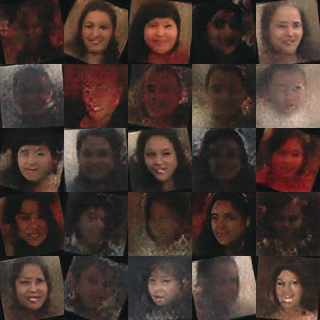

In [20]:
# 出力画像の確認
from IPython.display import Image, display_png

final_img = "{dir}/generated_{step}.png".format(dir=IMG_SAVE_DIR, step=TOTAL_STEPS)
display_png(Image(final_img))

In [22]:
# 学習したジェネレータで画像を生成してみる
z = np.random.uniform(-1, 1, (BATCH_SIZE, z_size))
img_g = generator.predict(z)

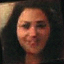

In [24]:
array_to_img(img_g[0])

In [25]:
# 実画像
batch = train_data_generator.next()

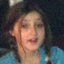

In [27]:
array_to_img(batch[0])

In [28]:
# 実画像をエンコーダーデコーダーで再構成する
real_reconstruct_imgs = discriminator.predict(batch)

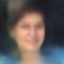

In [30]:
array_to_img(real_reconstruct_imgs[0])

In [31]:
# fake画像をエンコーダーデコーダーで再構成する
fake_reconstruct_imgs = discriminator.predict(img_g)

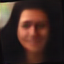

In [32]:
array_to_img(fake_reconstruct_imgs[0])